# Install some necessary libraries

In [1]:
!pip install momepy
!pip install osmnx

## Please insert your file path and network you want to evaluate here

In [2]:
file_path = 'H:/mmmiah/Desktop/Bicycle Connectivity Project/Caltrans_Script/Using _LTS1.0'
# Please insert JSON file
Your_evaluated_network_file="complete_network_SF.json"
# Please show the path where you want to store the results
your_results_file_path='H:/mmmiah/Desktop/Bicycle Connectivity Project/Caltrans_Script/Using _LTS1.0/results'

In [3]:
# Import Necessary Library

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import Point
from functools import reduce
#import matplotlib.pyplot as plt  ## not needed
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import csv
from time import time
import time
from geopandas import GeoSeries, GeoDataFrame

In [6]:
# Define the Helper Function

In [7]:
# write a slope impedance function
def slope_correction(length,LTS,slope):
    if slope <=2:
        return length*(1+LTS)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+LTS)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+LTS)
    else:
        return length*(1+3.20+LTS)

In [8]:
def node_level_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_sheortst_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # We will consider no connection means infinite distance, therefore replace all zero distance with inf
    sf_sheortst_path_motor_length1 = sf_sheortst_path_motor_length.replace(0, np.inf)
    sf_sheortst_path_motor_length2 = sf_sheortst_path_motor_length1.replace(np.NaN, np.inf)
    # take the reciprocal of distance
    sf_sheortst_path_motor_length_reciprocal=1/sf_sheortst_path_motor_length2
    # Calculate the total reciprocal distance
    sf_sheortst_path_motor_length_reciprocal['node_complete_network_path_reciprocal_sum']=sf_sheortst_path_motor_length_reciprocal.sum(numeric_only=True, axis=0)
    sf_sheortst_path_motor_length_reciprocal1=sf_sheortst_path_motor_length_reciprocal[['node_complete_network_path_reciprocal_sum']]
    #sf_sheortst_path_motor_length1
    # make total motor path as dictonary
    ms_outcomes=sf_sheortst_path_motor_length_reciprocal1.T.to_dict('list')
    ms_outcomes
    # # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_motor_g1, values=ms_outcomes, name="node_complete_network_path_reciprocal_sum")
    nodes_motor, edges_motor = momepy.nx_to_gdf(sf_lts_motor_g1)
    nodes_motor['node_complete_network_path_reciprocal_sum'] = nodes_motor['node_complete_network_path_reciprocal_sum'].str[0]


    # do it for bike Path or low-stress path
    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # We will consider no connection means infinite distance, therefore replace all zero and NaN distance with inf
    sf_shortest_path_bike_length1 =  sf_shortest_path_bike_length.replace(0, np.inf)
    sf_shortest_path_bike_length2 = sf_shortest_path_bike_length1.replace(np.NaN, np.inf)
    # take the reciprocal of distance
    sf_shortest_path_bike_length_reciprocal=1/sf_shortest_path_bike_length2
    # Calculate the total reciprocal distance
    sf_shortest_path_bike_length_reciprocal['bike_or_low_stress_path_reciprocal_sum']=sf_shortest_path_bike_length_reciprocal.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_reciprocal1=sf_shortest_path_bike_length_reciprocal[['bike_or_low_stress_path_reciprocal_sum']]
    # make total motor path as dictonary
    bs_outcomes=sf_shortest_path_bike_length_reciprocal1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_bike_g1, values=bs_outcomes, name="bike_or_low_stress_path_reciprocal_sum")
    nodes_bike, edges_bike = momepy.nx_to_gdf(sf_lts_bike_g1)
    nodes_bike['bike_or_low_stress_path_reciprocal_sum'] = nodes_bike['bike_or_low_stress_path_reciprocal_sum'].str[0]

    #connectivity score
    shortest_path=pd.merge(nodes_motor,nodes_bike,on=['geometry'],how='outer')
    shortest_path=shortest_path.fillna(0)
    shortest_path['CS']= (shortest_path['bike_or_low_stress_path_reciprocal_sum'])/(shortest_path['node_complete_network_path_reciprocal_sum'])
    # The connectivity score will always varied from zero to one, however, due to missing link in complete network can get the CS more than one, therefore, we will limit this one to avoid any unexpected error
    shortest_path['CS'] = shortest_path['CS'].clip(upper=1)
    #shortest_path1= shortest_path1.replace(np.inf, 1)
    return shortest_path

In [31]:
# define grade of connectivity
def count_census_block(Connectivity_score):
    if Connectivity_score>=0.80:
        return 'excellently connected'
    elif (Connectivity_score>=0.60 and Connectivity_score<0.80):
        return 'very well connected  '
    elif (Connectivity_score>=0.40 and Connectivity_score<0.60):
        return 'well connected'
    elif (Connectivity_score>=0.20 and Connectivity_score<0.40):
        return 'fairly connected'
    else:
        return 'poorly connected'

In [10]:
def census_node_level_connectivity_score (sf_connectivity,input_census_tract):
    census_score=gpd.sjoin(sf_connectivity,input_census_tract)
    census_score1=pd.DataFrame({'Meadian CS':census_score.groupby(['GISJOIN'])['CS'].median()}).reset_index()
    census_score2=pd.merge(census_score1,input_census_tract, on=['GISJOIN'], how='inner' )
    return census_score2

# Import the necessary input file

# We provided pre calculated slope and LTS for the entire Bay Area. You do not need to chnage it for the any network within bay area evaluation

In [11]:
# we will import pre-calculated slope and LTS file for the entire BAY Area. You can also calculate the LTS using Pybna desktop notebook and Slope using raster file as shown in our notebook.
# Import the necessary file, here we will import entire bay area pre-calculated slope and LTS file
import warnings
warnings.filterwarnings('ignore')
slope_lts=gpd.read_file(f"{file_path}/Bay_area_slope_LTS_Nov7.json")
slope_lts1 = gpd.GeoDataFrame(slope_lts, crs="EPSG:4326", geometry='geometry')
#slope_lts2=slope_lts.to_crs(epsg=7131)
#slope_lts2['geometry'].plot()

In [12]:
slope_lts1.head()

,ROAD_ID,FUNCTIONAL,Facilities,LTS,length,slope,geometry
0,111276,tertiary,0,4,24.398252,0.000000,"LINESTRING (-121.95749 37.52394, -121.95722 37..."
1,162454,tertiary,0,4,75.902661,3.952431,"LINESTRING (-121.76918 37.31464, -121.76834 37..."
2,165633,primary,0,4,37.835842,0.000000,"LINESTRING (-121.92277 37.32337, -121.92235 37..."
3,888344,tertiary,0,4,1.539394,0.000000,"LINESTRING (-122.24642 37.78016, -122.24640 37..."
4,923150,residential,0,1,3.697954,0.000000,"LINESTRING (-122.51925 38.05433, -122.51929 38..."


# Only Insert your road network shape file here, we Just need the geometry to create the study area shape file

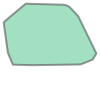

In [13]:
# Import the road network that you want to evalaute, this network will be used to create the study area boundary
road_network=gpd.read_file(f"{file_path}/{Your_evaluated_network_file}")
#road_network= gpd.GeoDataFrame(road_network, crs="EPSG:4326", geometry='geometry')
road_network_proj = road_network.to_crs(epsg=4326)
convex_hull_area = road_network.unary_union.convex_hull
convex_hull_area

# This Census track is already set for Bay Area, you do not need to change anything for the network within Bay Area

<AxesSubplot: >

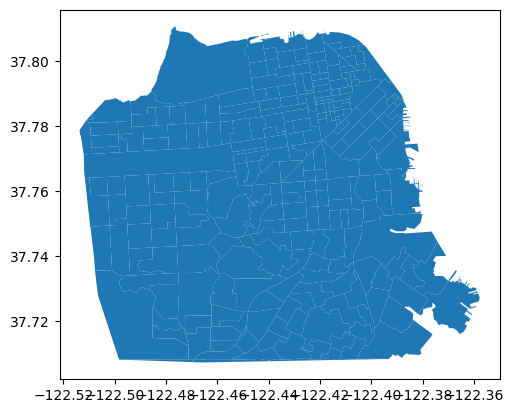

In [14]:
# Import the census track
census_track=gpd.read_file(f"{file_path}/Bay_area_census_tract.json")
census_track1= gpd.GeoDataFrame(census_track, crs="EPSG:4326", geometry='geometry')
evalauted_census_track=gpd.clip(census_track1,convex_hull_area)
evalauted_census_track.plot()

# Now calculate the algorithm weighting imedance

In [15]:
#Network to be evaluated
complete_network=gpd.clip(slope_lts1,convex_hull_area)
complete_network['LTS']=pd.to_numeric(complete_network['LTS']).astype(int)
complete_network['impedance_of_link']=complete_network.apply(lambda row: slope_correction(row['length'],row['LTS'],row['slope']),axis=1)
complete_network.shape

(29167, 8)

In [29]:
# save the complete network
# crs = {'init': 'epsg:4326'}
# complete_network = gpd.GeoDataFrame(complete_network, crs=crs, geometry = 'geometry')
# complete_network.to_file(f"{your_results_file_path}/Complete_Network.json", driver="GeoJSON")

## Calculate the BNC Score

In [16]:
# Filter the bike network based on forward bike facilities
bike_network=complete_network.loc[complete_network['Facilities']!='0']
bike_network.head()

,ROAD_ID,FUNCTIONAL,Facilities,LTS,length,slope,geometry,impedance_of_link
731,850531,primary,lane,4,666.102808,0.750635,"LINESTRING (-122.50310 37.72452, -122.50308 37...",3330.514041
503037,915238,residential,sharrow,1,142.162794,0.000000,"LINESTRING (-122.51018 37.77505, -122.51009 37...",284.325588
286550,889669,path,path,1,9.867345,0.000000,"LINESTRING (-122.51124 37.77499, -122.51113 37...",19.734691
157063,918591,path,path,1,10.789009,0.000000,"LINESTRING (-122.51137 37.77500, -122.51124 37...",21.578019
84471,918592,path,path,1,16.474654,0.000000,"LINESTRING (-122.51155 37.77500, -122.51137 37...",32.949307


In [30]:
# save the complete network
# crs = {'init': 'epsg:4326'}
# bike_network = gpd.GeoDataFrame(bike_network, crs=crs, geometry = 'geometry')
# bike_network.to_file(f"{your_results_file_path}/Bike_Network.json", driver="GeoJSON")

In [17]:
%%time
# Now Calculate the BNC node score
bnc_node_score=node_level_connectivity_score (complete_network,bike_network)
# Calculate the BNC area score
bnc_area_score1=bnc_node_score['bike_or_low_stress_path_reciprocal_sum'].sum()/bnc_node_score['node_complete_network_path_reciprocal_sum'].sum()
print('Area Connectivity_Score Using BNC:',bnc_area_score1)

Area Connectivity_Score Using BNC: 0.06670256783036511
CPU times: total: 1h 3min 9s
Wall time: 1h 3min 13s


In [28]:
# Save the Node Connectivity Score
crs = {'init': 'epsg:4326'}
bnc_node_score1 = gpd.GeoDataFrame(bnc_node_score, crs=crs, geometry = 'geometry')
bnc_node_score1.to_file(f"{your_results_file_path}/Network_node_BNC_updated_score.json", driver="GeoJSON")

In [32]:
# Summarize the BNC score by census track by taking the median of census track node and grade it
CS_median=census_node_level_connectivity_score (bnc_node_score,evalauted_census_track)
CS_median['cs_ranking']=CS_median.apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
fairly connected     17
poorly connected    230
Name: GISJOIN, dtype: int64

In [20]:
# save the Census Tract Connectivity Score
crs = {'init': 'epsg:4326'}
CS_median_bnc = gpd.GeoDataFrame(CS_median, crs=crs, geometry = 'geometry')
CS_median_bnc.to_file(f"{your_results_file_path}/Network_census_BNC_updated_score.json", driver="GeoJSON")

# Calculate the LSBNC Score

In [21]:
# filter the low stress network by taking LTS 1 and LTS 2 from complete network
low_stress_network=complete_network.loc[complete_network['LTS']<3]

In [22]:
%%time
node_LSBNC_score= node_level_connectivity_score(complete_network,low_stress_network)
lsbnc_area_score=node_LSBNC_score['bike_or_low_stress_path_reciprocal_sum'].sum()/node_LSBNC_score['node_complete_network_path_reciprocal_sum'].sum()
print('Area Connectivity_Score Using LSBNC:',lsbnc_area_score)

Area Connectivity_Score Using LSBNC: 0.21124330557698276
CPU times: total: 1h 7min 31s
Wall time: 1h 7min 41s


In [23]:
# Save the Node connectivity score
crs = {'init': 'epsg:4326'}
node_LSBNC_score1 = gpd.GeoDataFrame(node_LSBNC_score, crs=crs, geometry = 'geometry')
node_LSBNC_score1.to_file(f"{your_results_file_path}/Network_node_LSBNC_updated_score.json", driver="GeoJSON")

In [33]:
# summarize the LSBNC score using five grade by census track
CS_median_lsbnc=census_node_level_connectivity_score (node_LSBNC_score,evalauted_census_track)
CS_median_lsbnc['cs_ranking']=CS_median_lsbnc.apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median_lsbnc.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
fairly connected     66
poorly connected    120
well connected       61
Name: GISJOIN, dtype: int64

In [25]:
# save the census tract connectivity score
crs = {'init': 'epsg:4326'}
CS_median_lsbnc1 = gpd.GeoDataFrame(CS_median_lsbnc, crs=crs, geometry = 'geometry')
CS_median_lsbnc1.to_file(f"{your_results_file_path}/Network_census_LSBNC_updated_score.json", driver="GeoJSON")

In [26]:
# Make pandas data frame for area connectivity using BNC and LSBNC algorithm togther and save it as excel
output = {'BNC_Score': [bnc_area_score1],
        'LSBNC_Score': [lsbnc_area_score]}

score = pd.DataFrame(output)
# save the score
score.to_csv(f"{your_results_file_path}/Connectivity_updated_score.csv")
score

,BNC_Score,LSBNC_Score
0,0.066703,0.211243


# End of the code